<a href="https://colab.research.google.com/github/LM1997610/NN/blob/main/NN_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the dataset

In [1]:
! pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
dataset = load_dataset(path='Francesco/apex-videogame')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2583
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 415
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 691
    })
})

In [5]:
train_data = dataset['train']
test_data = dataset['test']

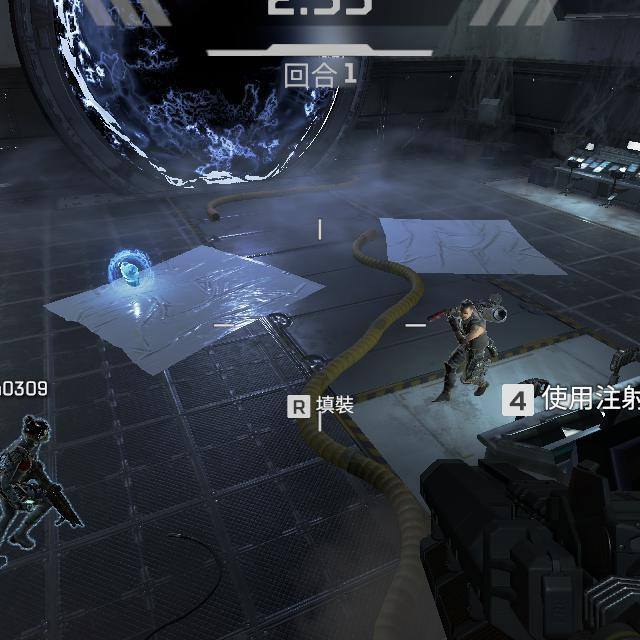

In [27]:
test_data[18]['image']

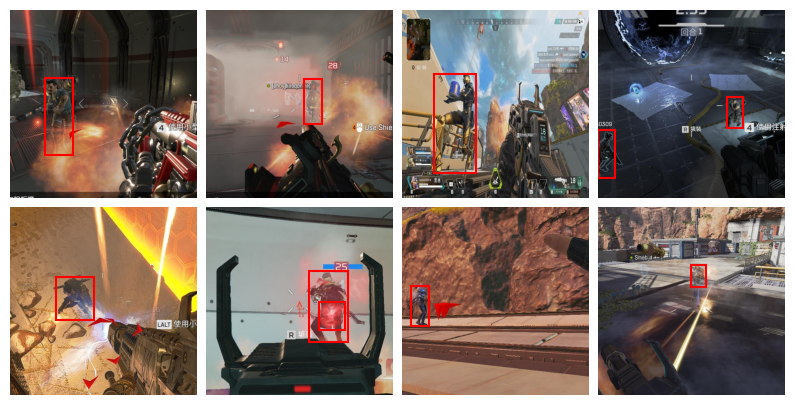

In [33]:
images_to_show = [5, 6, 10, 18, 25, 332, 567, 690]

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(test_data[images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  for bbox in test_data[images_to_show[image_n]]['objects']['bbox']:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Load the model

In [34]:
! pip install -q --upgrade keras-cv

In [35]:
import os

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

In [36]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset("yolo_v8_m_pascalvoc",
                                                              bounding_box_format="xywh")

In [37]:
inference_resizing = keras_cv.layers.Resizing(640, 640,
                                              pad_to_aspect_ratio=True,
                                              bounding_box_format="xywh")

In [38]:
imgs_to_try = []

for img_index in images_to_show:
  this_img = np.array(test_data[img_index]['image'])
  imgs_to_try.append(this_img)

image_batch = inference_resizing(imgs_to_try)

In [39]:
y_pred = pretrained_model.predict(image_batch)

1/1 [==============================] - 34s 34s/step


In [42]:
def get_bbox_and_confidence(data_pred, index):

  bounding_box = data_pred['boxes'][index]
  filtered_boxes = bounding_box[~np.all(bounding_box == -1, axis=1)]

  confidences = []
  for i in range(len(filtered_boxes)):
    this_conf = data_pred['confidence'][index][i]
    confidences.append(round(this_conf,3))

  return {'boxes': filtered_boxes, 'confidence': confidences}

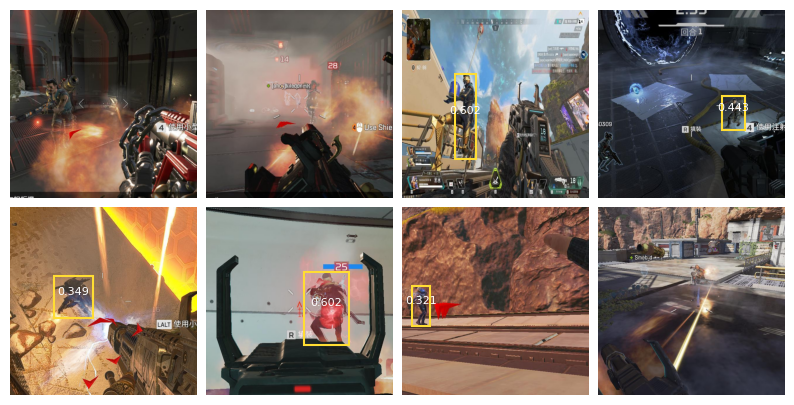

In [43]:

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(test_data[images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  this_diz = get_bbox_and_confidence(y_pred, image_n)

  for bbox_idx in range(len(this_diz['boxes'])):
    x, y, w, h = this_diz['boxes'][bbox_idx]
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='#FFDD33', facecolor='none')
    ax.add_patch(rect)
    text = this_diz['confidence'][bbox_idx]
    ax.text(x+w/2, y+h/2, text, ha='center', va='bottom', color='white', fontsize=8)


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()